In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [2]:
import sys
sys.path.append(os.path.realpath('../../..'))

In [3]:
from tqdm.auto import tqdm
from typing import List
import re
from typing import List, Tuple, Dict
from data.dataset import GraphDataset, ReimburseGraphDataset, DataAugmentationLevel, DialogNode, NodeType
import seaborn as sns
import pandas

/mount/arbeitsdaten/asr-2/vaethdk/virtualenvs/cts_en/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = 'cuda:0'
import torch
# a= torch.zeros(1,1,device=DEVICE)

In [5]:
human_data_train = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../../resources/")
human_data_test = ReimburseGraphDataset('en/reimburse/test_graph.json', 'en/reimburse/test_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../../resources/")
generated_data_train_v1 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v1.json", resource_dir="../../../resources/")
generated_data_train_v2 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v2.json", resource_dir="../../../resources/")
generated_data_train_v3 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v3.json", resource_dir="../../../resources/")

- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 279
- loaded original data: True
- loaded generated data: False
- not using synonyms
===== Dataset Statistics =====
- files:  en/test_graph.json en/test_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 173
- loaded original data: True
- loaded generated data: False
- Loading questions from  ../../../resources/en/generated/train_questions_v1.json
- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 1012
- loaded original data: False
- loaded generated data: True
- Loading questions from  ../../../resources/en/generated/train_questions_v2.json
- not using synonyms
===== Dataset Statistics =====
- files:  en/train_graph.json en/train_answers.json
- synonyms: Fals

# CALCULATING PERPLEXITY

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('gpt2-large', cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/")

In [22]:
model = AutoModelForCausalLM.from_pretrained('gpt2-large', cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/")

In [23]:
model = model.eval().to('cuda:0')

In [42]:
# import transformers 

# # set quantization configuration to load large model with less GPU memory
# # this requires the `bitsandbytes` library
# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# model_id = 'meta-llama/Llama-2-70b-chat-hf'
# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_id,
#     trust_remote_code=True,
#     quantization_config=bnb_config,
#     device_map='auto'
# )

In [25]:
def calculate_ppl(node: DialogNode) -> List[float]:
    """ 
    Returns 
        A list of token probabilities (one tensor per question)
        A list of token indices
    """
    # generate prompt
    ppls = []
    with torch.no_grad():
        for question in node.questions:
            prompt = question.text
            # forward prompt
            inputs = tokenizer(prompt, return_tensors='pt').input_ids.to('cuda:0')
            output = model(input_ids=inputs, labels=inputs)
            ppl = torch.exp(output.loss.squeeze())
            ppls.append(ppl.item())
    return ppls


In [26]:
def load_ppl(ppl_file: str) -> List[float]:
    # Calculate perplexity of human data 
    ppls = torch.load(ppl_file, map_location=lambda storage, loc: storage)
    perplexities = []
    for node_key in ppls:
        node_data = ppls[node_key] # list with probabilities per question
        perplexities.extend(node_data)
    print(ppl_file, ":", len(perplexities), "samples")
    return perplexities

### HUMAN QUESTION PERPLEXITY

In [27]:
data = {}
for node in tqdm(human_data_train.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs.pt")

100%|██████████| 80/80 [00:07<00:00, 11.31it/s]


In [28]:
data = {}
for node in tqdm(human_data_test.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs_testdata.pt")

100%|██████████| 80/80 [00:04<00:00, 18.45it/s]


In [29]:
data = {}
for node in tqdm(generated_data_train_v1.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v1.pt")

100%|██████████| 80/80 [00:20<00:00,  3.86it/s]


In [30]:
data = {}
for node in tqdm(generated_data_train_v2.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v2.pt")

100%|██████████| 80/80 [00:20<00:00,  3.88it/s]


In [31]:
data = {}
for node in tqdm(generated_data_train_v3.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v3.pt")

100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


In [32]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "ppl": ppl} for ppl in load_ppl('human_question_probs.pt')] + 
    [{"source": "human_questions_test", "ppl": ppl} for ppl in load_ppl('human_question_probs_testdata.pt')] +
    [{"source": 'generated v1', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v1.pt')] +
    [{"source": 'generated v2', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v2.pt')] +
    [{"source": 'generated v3', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v3.pt')]
)

human_question_probs.pt : 269 samples
human_question_probs_testdata.pt : 167 samples
generated_question_probs_v1.pt : 800 samples
generated_question_probs_v2.pt : 800 samples
generated_question_probs_v3.pt : 417 samples


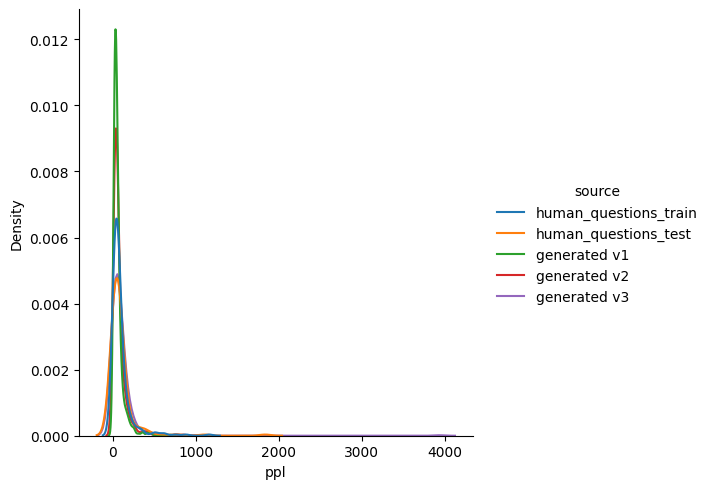

In [35]:
sns.displot(df.reset_index(drop=True), x="ppl", kind="kde", hue='source', common_norm=False)

## Question Lengths

In [16]:
def calculate_question_length(data: GraphDataset):
    question_length = []
    for node in tqdm(data.nodes_by_type[NodeType.INFO]):
        for question in node.questions:
            question_length.append(len(question.text.split(" ")))
    return question_length

In [17]:
question_length_human_train = calculate_question_length(human_data_train)
question_length_human_test = calculate_question_length(human_data_test)
question_length_generated_v1 = calculate_question_length(generated_data_train_v1)
question_length_generated_v2 = calculate_question_length(generated_data_train_v2)
question_length_generated_v3 = calculate_question_length(generated_data_train_v3)

100%|██████████| 80/80 [00:00<00:00, 115984.90it/s]


In [18]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "#words": length} for length in question_length_human_train] + 
    [{"source": "human_questions_test", "#words": length} for length in question_length_human_test] +
    [{"source": 'generated v1', "#words": length} for length in question_length_generated_v1] + 
    [{"source": 'generated v2', "#words": length} for length in question_length_generated_v2] +
    [{"source": 'generated v3', "#words": length} for length in question_length_generated_v3] 
)

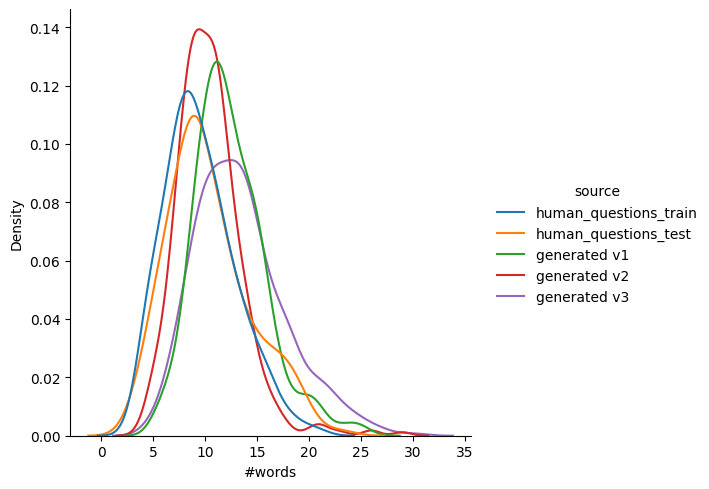

In [19]:
sns.displot(df.reset_index(drop=True), x="#words", kind="kde", hue='source', common_norm=False)

## Question Similarities

Two scenarios:

1. Pair-wise question similarity between all questions of a node (WITHIN the same dataset)
2. Pair-wise question similarity between the questions of a node from one dataset and the questions from another dataset

In [24]:
from data.dataset import Question
from sentence_transformers import SentenceTransformer, util

similarity_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=DEVICE, cache_folder = '/mount/arbeitsdaten/asr-2/vaethdk/resources/weights').to(DEVICE)

In [25]:
def calculate_similarity(questions_1: List[Question], questions_2: List[Question]):
    #Compute embedding for both lists
    embeddings1 = similarity_model.encode([q.text for q in questions_1], convert_to_tensor=True)
    embeddings2 = similarity_model.encode([q.text for q in questions_2], convert_to_tensor=True)

    #Compute pair-wise cosine-similarities -> #questions_1 x #questions_2
    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    return cosine_scores.to("cpu")


#### 1. scenario: Pair-wise question similarity between all questions of a node (WITHIN the same dataset)

In [26]:
def within_dataset_similarity(dataset: GraphDataset) -> List[float]:
    similarities = []
    for node in tqdm(dataset.nodes_by_type[NodeType.INFO]):
        if len(node.questions) > 0:
            pariwise_sim = calculate_similarity(node.questions, node.questions)
            # ignore self-similarity (matrix diagnoal)
            # also: matrix is symmetric
            # --> only look at triangle above diagonal
            pariwise_sim = torch.triu(pariwise_sim, diagonal=1) # will set elements on and below diagonal to 0
            pariwise_sim = pariwise_sim.view(-1) # convert to list
            relevant_elements = pariwise_sim[pariwise_sim.nonzero()].view(-1) # extract nonzero entries
            similarities.extend(relevant_elements.tolist())     
    return similarities           

In [27]:
human_train_similarity = within_dataset_similarity(human_data_train)
human_test_similarity = within_dataset_similarity(human_data_test)
generated_similarity_v1 = within_dataset_similarity(generated_data_train_v1)
generated_similarity_v2 = within_dataset_similarity(generated_data_train_v2)
generated_similarity_v3 = within_dataset_similarity(generated_data_train_v3)

100%|██████████| 80/80 [00:03<00:00, 21.24it/s]


In [28]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "similarity": sim} for sim in human_train_similarity] + 
    [{"source": "human_questions_test", "similarity": sim} for sim in human_test_similarity] +
    [{"source": 'generated v1', "similarity": sim} for sim in generated_similarity_v1] + 
    [{"source": 'generated v2', "similarity": sim} for sim in generated_similarity_v2] +
    [{"source": 'generated v3', "similarity": sim} for sim in generated_similarity_v3]
)

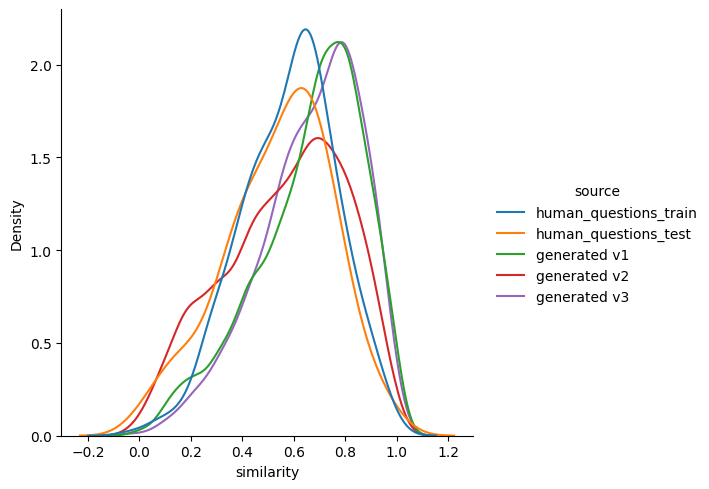

In [29]:
sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

#### 2. scenario: Pair-wise question similarity between the questions of a node from one dataset and the questions from another dataset

In [30]:
def between_dataset_similarity(dataset_1: GraphDataset, dataset_2: GraphDataset) -> List[float]:
    similarities = []
    for node_1 in tqdm(dataset_1.nodes_by_type[NodeType.INFO]):
        node_2 = dataset_2.nodes_by_key[node_1.key]
        if len(node_1.questions) > 0 and len(node_2.questions) > 0:
            pariwise_sim = calculate_similarity(node_1.questions, node_2.questions)
            pariwise_sim = pariwise_sim.view(-1) # convert to list
            similarities.extend(pariwise_sim.tolist())     
    return similarities           

In [31]:
sim_human_train_vs_human_test = between_dataset_similarity(human_data_train, human_data_test)

sim_human_train_vs_generated_v1 = between_dataset_similarity(human_data_train, generated_data_train_v1)
sim_human_train_vs_generated_v2 = between_dataset_similarity(human_data_train, generated_data_train_v2)
sim_human_train_vs_generated_v3 = between_dataset_similarity(human_data_train, generated_data_train_v3)

sim_human_test_vs_generated_v1 = between_dataset_similarity(human_data_test, generated_data_train_v1)
sim_human_test_vs_generated_v2 = between_dataset_similarity(human_data_test, generated_data_train_v2)
sim_human_test_vs_generated_v3 = between_dataset_similarity(human_data_test, generated_data_train_v3)

100%|██████████| 80/80 [00:02<00:00, 27.80it/s]


In [32]:
df = pandas.DataFrame(
    [{"source": "human(train) vs human(test)", "similarity": sim} for sim in sim_human_train_vs_human_test] + 
    [{"source": "human(train) vs generated v1", "similarity": sim} for sim in sim_human_train_vs_generated_v1] +
    [{"source": "human(train) vs generated v2", "similarity": sim} for sim in sim_human_train_vs_generated_v2] +
    [{"source": "human(train) vs generated v3", "similarity": sim} for sim in sim_human_train_vs_generated_v3] +
    [{"source": 'human(test) vs generated v1', "similarity": sim} for sim in sim_human_test_vs_generated_v1] + 
    [{"source": 'human(test) vs generated v2', "similarity": sim} for sim in sim_human_test_vs_generated_v2] + 
    [{"source": 'human(test) vs generated v3', "similarity": sim} for sim in sim_human_test_vs_generated_v3] 
)

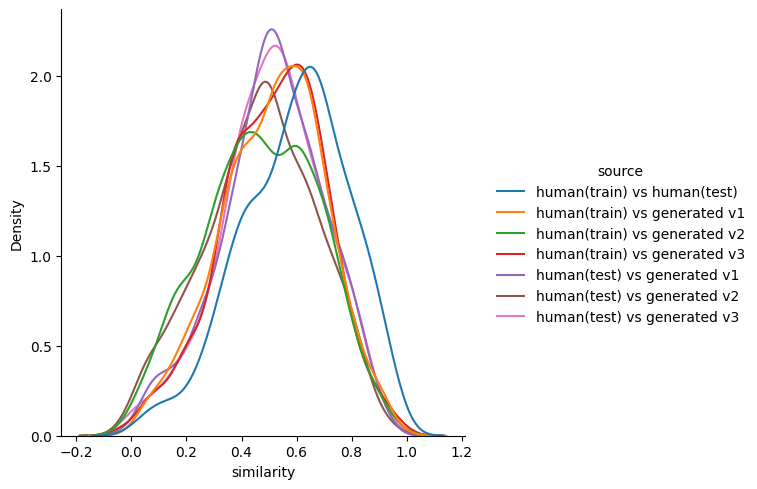

In [33]:
sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

100%|██████████| 80/80 [00:03<00:00, 23.33it/s]


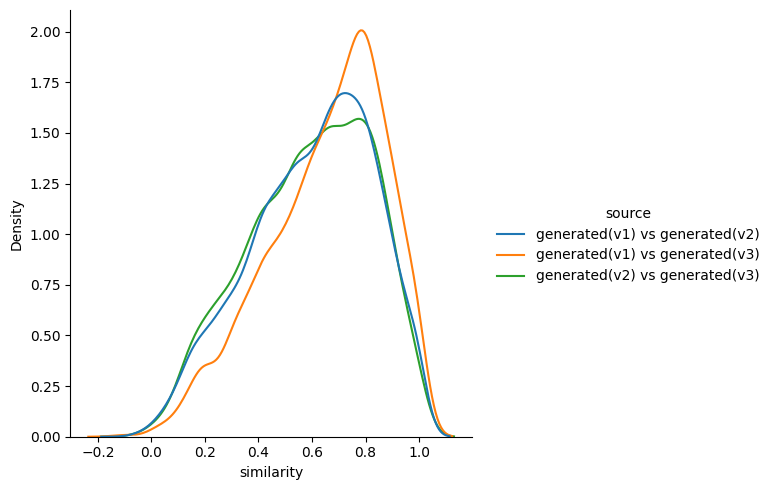

In [38]:
sim_generated_v1_vs_generated_v2 = between_dataset_similarity(generated_data_train_v1, generated_data_train_v2)
sim_generated_v1_vs_generated_v3 = between_dataset_similarity(generated_data_train_v1, generated_data_train_v3)
sim_generated_v2_vs_generated_v3 = between_dataset_similarity(generated_data_train_v2, generated_data_train_v3)

df = pandas.DataFrame(
    [{"source": 'generated(v1) vs generated(v2)', "similarity": sim} for sim in sim_generated_v1_vs_generated_v2] + 
    [{"source": 'generated(v1) vs generated(v3)', "similarity": sim} for sim in sim_generated_v1_vs_generated_v3] +
    [{"source": 'generated(v2) vs generated(v3)', "similarity": sim} for sim in sim_generated_v2_vs_generated_v3]
)

sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

# Conclusions

1. Generate shorter questions
2. Generate more diverse questions 